In [5]:
%pip install --upgrade xlrd

  Obtaining dependency information for xlrd from https://files.pythonhosted.org/packages/a6/0c/c2a72d51fe56e08a08acc85d13013558a2d793028ae7385448a6ccdfae64/xlrd-2.0.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 1.3 MB/s eta 0:00:00eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [28]:
class LogisticRegression:
    def __init__(self, learningRate, tolerance, maxIteration, removeIndex = []) -> None:
        self.tolerance = tolerance
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.removeIndex = removeIndex
  
    def readDataset(self):
        train_df = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2005 Data')
        test_df = pd.read_excel('Lab3_data.xls', sheet_name = '2004--2007 Data')

        train_df = self.remove_index(train_df)       

        train_df = np.array(train_df, dtype=np.float64)
        test_df = np.array(test_df, dtype=np.float64)

        X_train, y_train = train_df[:,1:], train_df[:,0]
        X_test, y_test = test_df[:,1:], test_df[:,0]

        return X_train, X_test, y_train, y_test
    
    def remove_index(self, train_df):
        if len(self.removeIndex) > 0:
            index = np.array(self.removeIndex) - 1
            train_df = train_df.drop(index)
        return train_df

    def sigmoid(self, z):
        sig = 1/(1+np.exp(-z))
        return sig

    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        # approach1
        cost = (y*np.log(sig)+(1-y)*np.log(1-sig)).sum()
        cost = -cost/X.shape[0]
        # approach2
        cost = (np.log(np.ones(X.shape[0])+np.exp(X.dot(self.w))-X.dot(self.w).dot(y)))
        cost = cost.sum()
        return cost
  
    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        gradient = (sig-y).dot(X)
        return gradient

    def gradientDescent(self, X, y):
        errors = []
        last_error = float('inf')
        for i in tqdm(range(self.maxIteration)):            
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_error = self.costFunction(X, y)
            diff = last_error - current_error
            last_error = current_error
            errors.append(current_error)

            if np.abs(diff) < self.tolerance:
                print('model stopped learning')
                break
        return
  
    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)               

    def evaluate(self, y, y_hat):
        y = (y==1)
        y_hat = (y_hat == 1)                
        recall = (y & y_hat).sum()/y.sum()
        precision = (y & y_hat).sum()/y_hat.sum()
        f_score = 2*(precision*recall)/(precision+recall)
        return f_score, recall, precision

    def fit(self):
        X_train, X_test, y_train, y_test = self.readDataset()
        print('Solving using GD')
        self.w = np.ones(X_train.shape[1], dtype=np.float64)*0
        self.gradientDescent(X_train, y_train)
        print(self.w)
        y_train_hat = self.predict(X_train)
        f_score, recall, precision = self.evaluate(y_train, y_train_hat)
        print('Training F1 score {}'.format(f_score))
        print('Training recall score {}'.format(recall))
        print('Training precision score {}'.format(precision))
        self.plot(X_train, y_train)
        self.scatterPlt(X_train, y_train)
        self.plot3D(X_train, y_train)


    def plot(self, X_train, y_train):
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(X_train[:, 0], X_train[:, 1], 
                    self.sigmoid(X_train.dot(self.w)), 
                    c = y_train[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0) 

  
    def scatterPlt(self, X_train, y_train):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                            np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(X_train[:, 0], X_train[:, 1], 
                  c=y_train[:], s=50,
                  cmap="RdBu", vmin=-.2, vmax=1.2,
                  edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')


    def plot3D(self, X_train, y_train):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                            np.linspace(y_min, y_max, 250))

        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(X_train[:, 0], X_train[:, 1], 
                  c=y_train[:], s=50,
                  cmap="RdBu", vmin=-.2, vmax=1.2,
                  edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()

### With elements on index [1, 39] present

In [29]:
lr = LogisticRegression(learningRate = 0.0001, 
                        tolerance = 0.00005, 
                        maxIteration = 50000)

Solving using GD


  0%|                                                 | 0/50000 [00:00<?, ?it/s]/var/folders/xz/k_fvgvyd1v17f34djsjq7v1w0000gn/T/ipykernel_15006/1125583658.py:35: RuntimeWarning: divide by zero encountered in log
  cost = (y*np.log(sig)+(1-y)*np.log(1-sig)).sum()
/var/folders/xz/k_fvgvyd1v17f34djsjq7v1w0000gn/T/ipykernel_15006/1125583658.py:35: RuntimeWarning: invalid value encountered in multiply
  cost = (y*np.log(sig)+(1-y)*np.log(1-sig)).sum()
/var/folders/xz/k_fvgvyd1v17f34djsjq7v1w0000gn/T/ipykernel_15006/1125583658.py:38: RuntimeWarning: invalid value encountered in log
  cost = (np.log(np.ones(X.shape[0])+np.exp(X.dot(self.w))-X.dot(self.w).dot(y)))
100%|██████████████████████████████████| 50000/50000 [00:01<00:00, 29654.16it/s]


[-1.09419876  0.60634705]
Training F1 score 0.9
Training recall score 1.0
Training precision score 0.8181818181818182


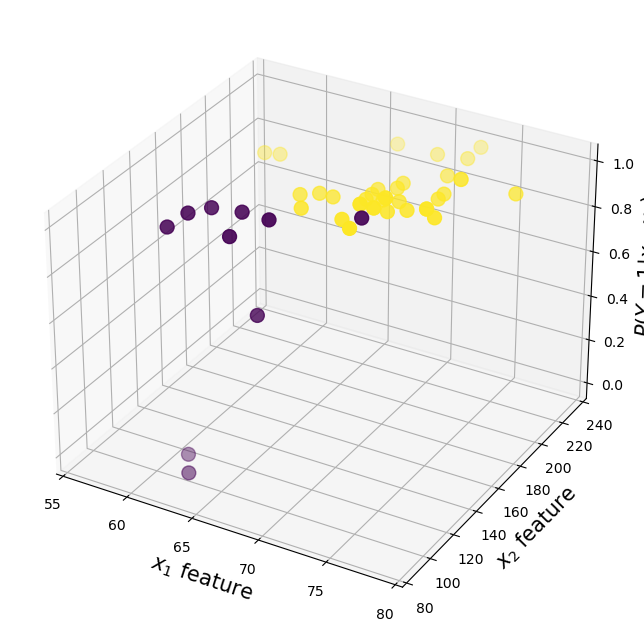

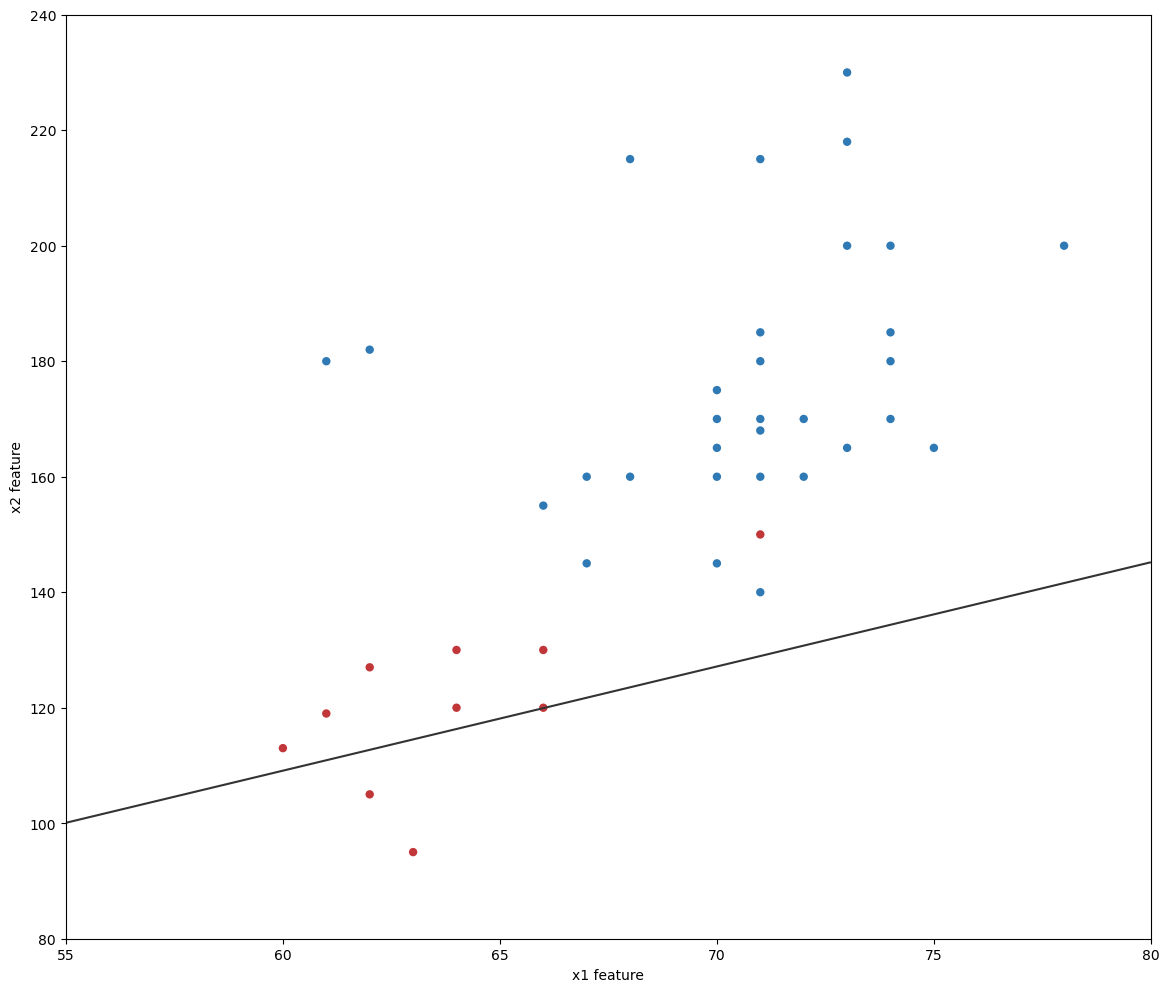

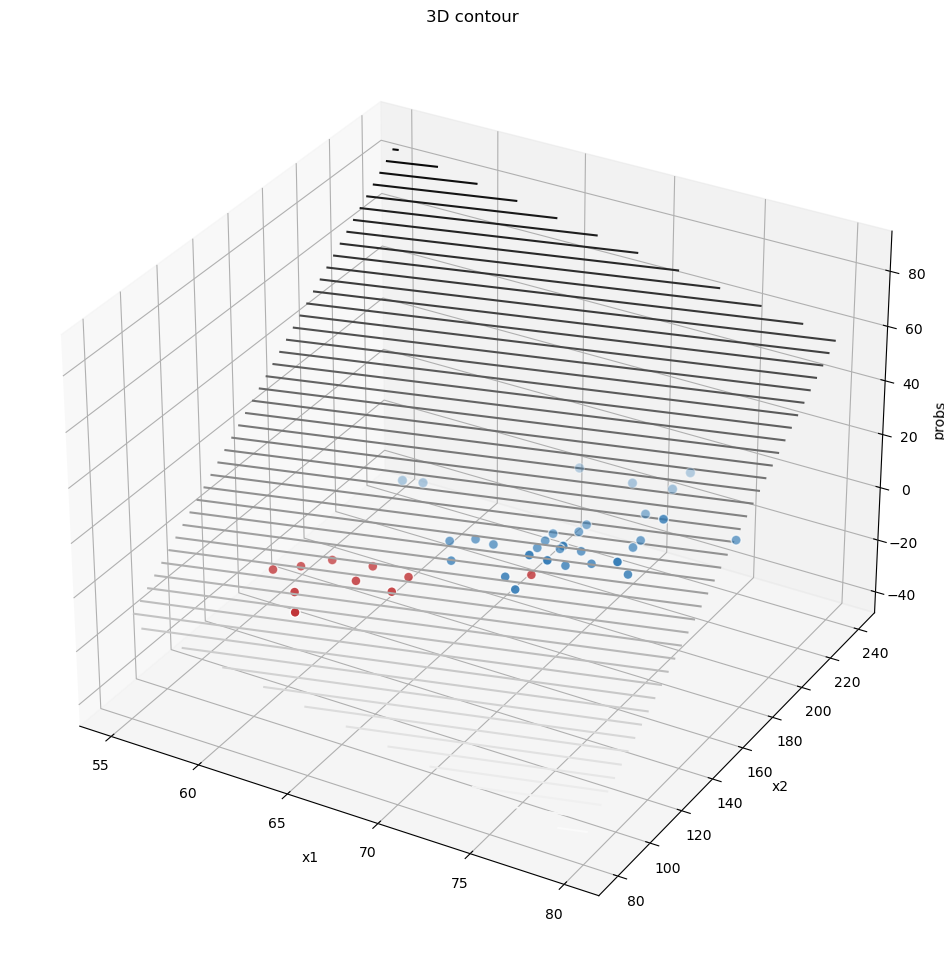

In [30]:
lr.fit()

### Without elements on index [1, 39] present

In [39]:
lr = LogisticRegression(learningRate = 0.0001, 
                        tolerance = 0.00005,
                        maxIteration = 50000,
                        removeIndex = [1, 39])

Solving using GD


  0%|                                                 | 0/50000 [00:00<?, ?it/s]/var/folders/xz/k_fvgvyd1v17f34djsjq7v1w0000gn/T/ipykernel_15006/1125583658.py:35: RuntimeWarning: divide by zero encountered in log
  cost = (y*np.log(sig)+(1-y)*np.log(1-sig)).sum()
/var/folders/xz/k_fvgvyd1v17f34djsjq7v1w0000gn/T/ipykernel_15006/1125583658.py:35: RuntimeWarning: invalid value encountered in multiply
  cost = (y*np.log(sig)+(1-y)*np.log(1-sig)).sum()
/var/folders/xz/k_fvgvyd1v17f34djsjq7v1w0000gn/T/ipykernel_15006/1125583658.py:38: RuntimeWarning: invalid value encountered in log
  cost = (np.log(np.ones(X.shape[0])+np.exp(X.dot(self.w))-X.dot(self.w).dot(y)))
100%|██████████████████████████████████| 50000/50000 [00:01<00:00, 35955.96it/s]


[-2.63523214  1.27817168]
Training F1 score 1.0
Training recall score 1.0
Training precision score 1.0


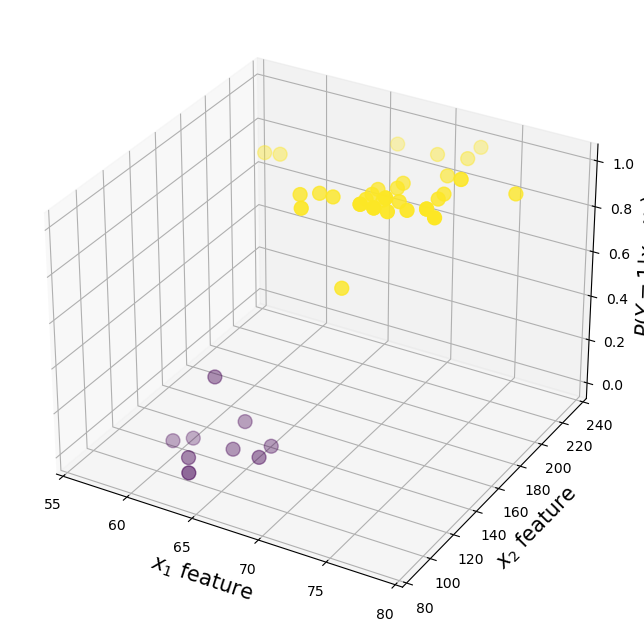

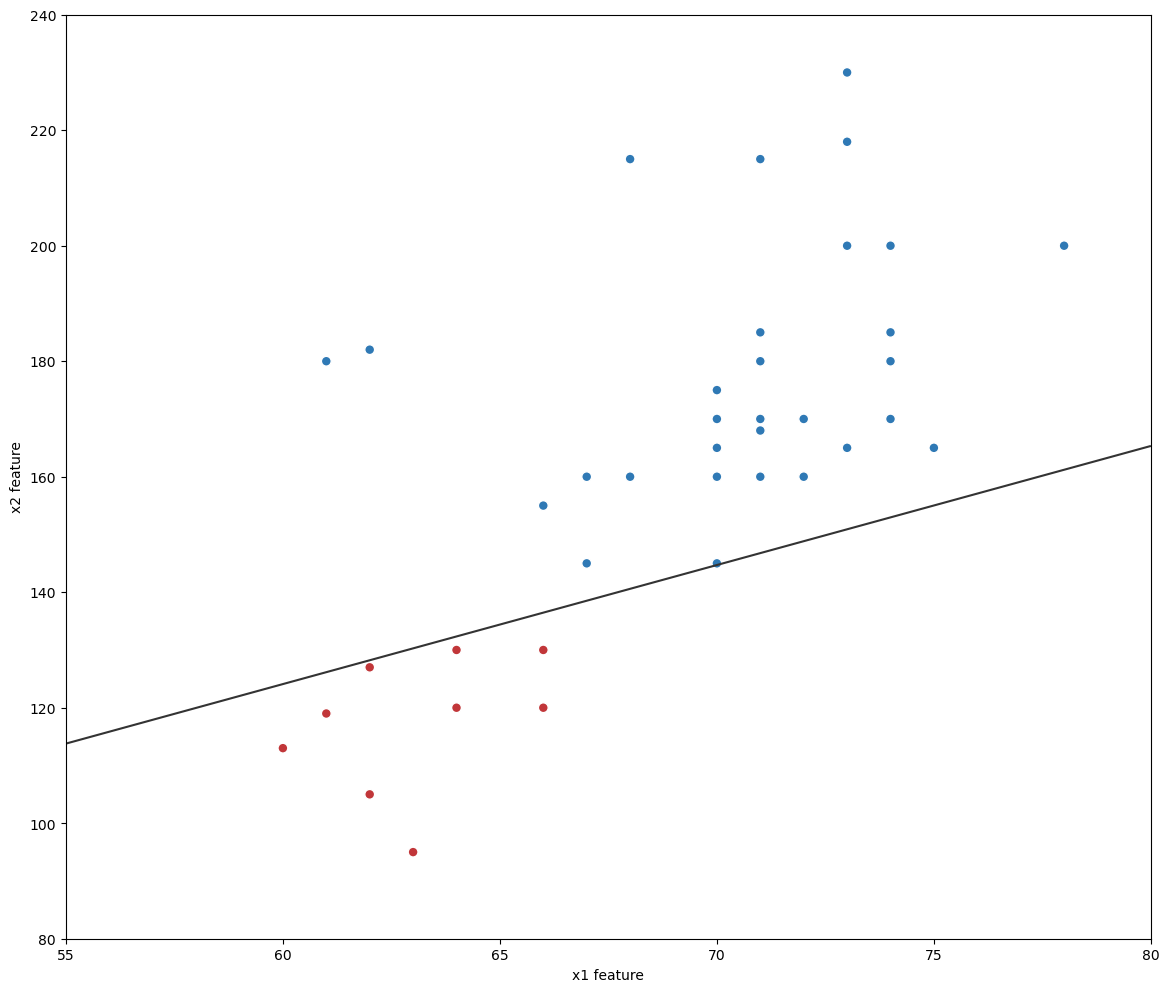

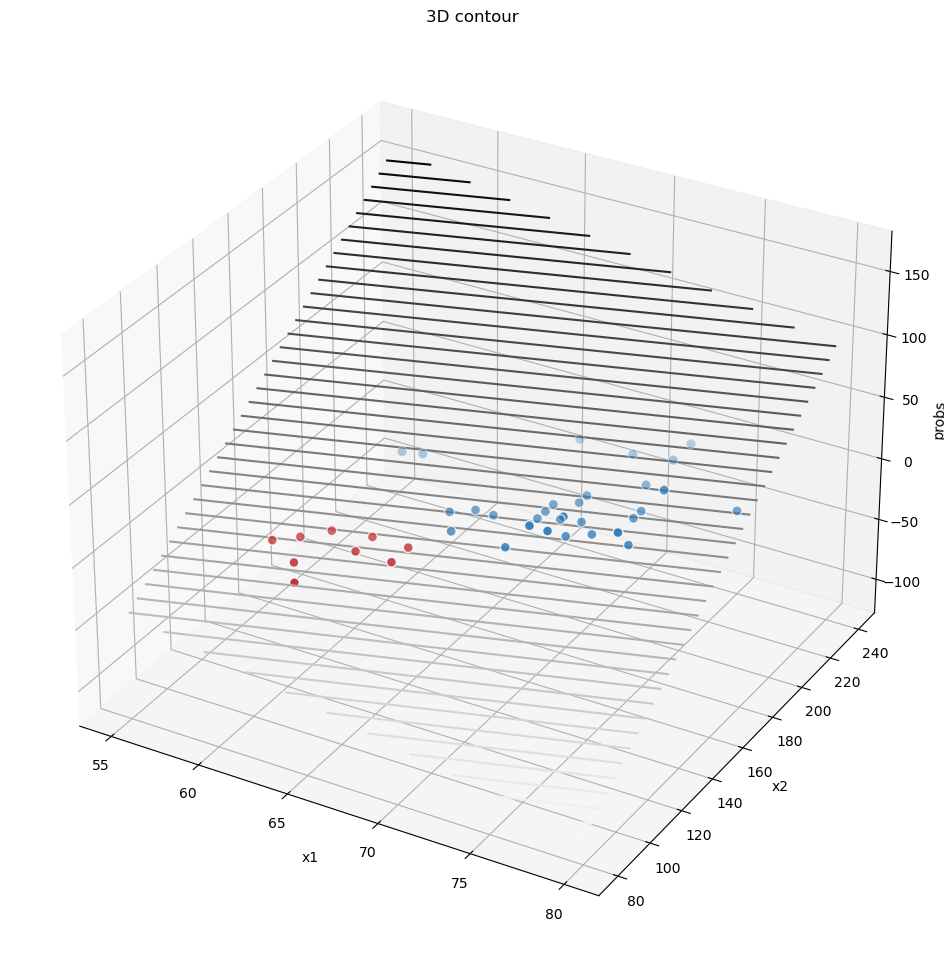

In [40]:
lr.fit()

#### Point number 1 and 39 are outliers for each of the class. Removing these outliers has large effect on predicted probability.